In [3]:
import sys
sys.path += ['../src/']
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
import numpy as np
import torch
import torch.optim as optim
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm
from scipy.special import logit, expit
import torch.nn as nn
from codetiming import Timer
from itertools import product

In [14]:
N, T, edge_per_t = 1000, 2000, 10
epsilon, mu = 0.002, 0.2
seed = 9
steepness = 1000

X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, steepness, seed)

In [15]:
max_d, min_d = sim_bc.max_min_interaction_distance(edges, X)
max_d, min_d

(0.005201207653835138, 0.00013652279052953076)

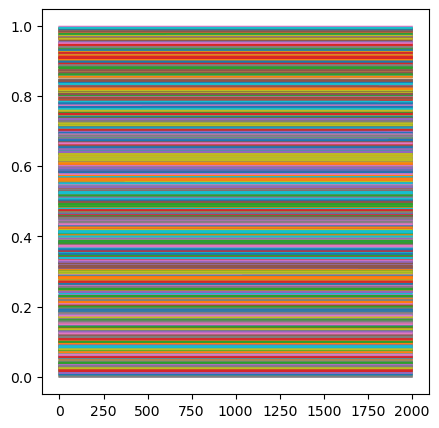

In [16]:
sim_bc.print_opinion_trajectory(X)

In [17]:
epsilon0, rho = 0.4, 100

In [18]:
with Timer():
    epsilon_scipy = est_bc.estimation_epsilon_scipy(rho, X, edges, epsilon0)

Elapsed time: 0.0646 seconds


In [19]:
with Timer():
    history_torch = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, 
                                                    num_epochs = 500)

epsilon_torch = history_torch["epsilon"][-1]

100%|████████████████████████████████████████| 500/500 [00:00<00:00, 602.73it/s]

Elapsed time: 0.8406 seconds


In [20]:
epsilon_scipy, epsilon_torch, epsilon

(0.0, 0.028071034348994068, 0.002)

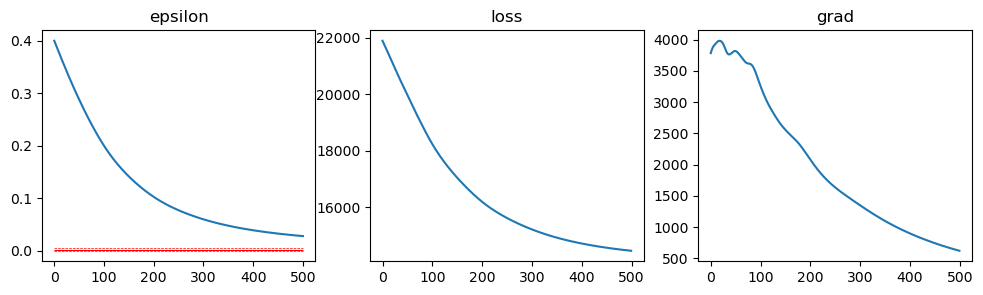

In [21]:
est_bc.print_history(history_torch, epsilon, max_d = max_d, min_d = min_d)

In [63]:
N, T, edge_per_t = 1000, 2000, 10
epsilon, mu = 0.2, 0.2
seed = 9
steepness = 18

epsilon0, rho = 0.4, 100

X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, steepness, seed)

In [64]:
epsilon_scipy = est_bc.estimation_epsilon_scipy(rho, X, edges, epsilon0)

history_torch = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, 
                                                num_epochs = 500)

epsilon_torch = history_torch["epsilon"][-1]

100%|█████████████████████████████████████████| 500/500 [00:12<00:00, 38.78it/s]


In [65]:
epsilon, epsilon_scipy, epsilon_torch

(0.2, 0.19323093293466095, 0.19316904754313774)

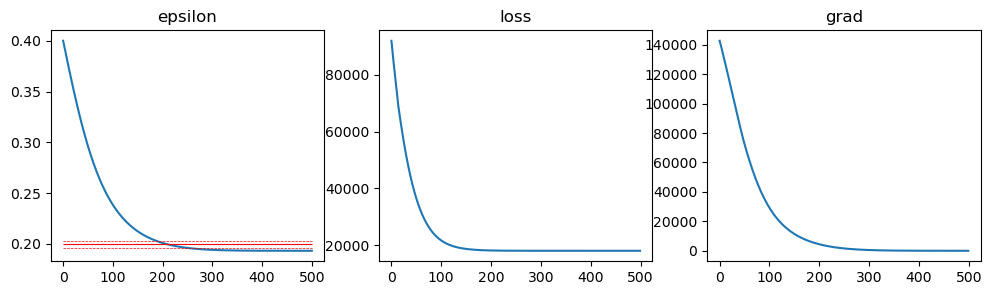

In [66]:
est_bc.print_history(history_torch, epsilon, max_d = max_d, min_d = min_d)

In [161]:
def repeat_estimations(N_list,T_list,edge_per_t_list,steepnesses,rhos,batch_sizes,scipy = True, print_progress = True, repetitions = 1):

    epsilon_scipy = 0
    histories = []

    tot_sim = len(N_list) * len(T_list) * len(edge_per_t_list) * len(steepnesses) * len(rhos) * repetitions * len(batch_sizes)
    print("Tot simulations", tot_sim)
    
    for _, batch_size, steepness, rho, edge_per_t, N, T in tqdm(product(np.arange(repetitions), batch_sizes, steepnesses,
                                                                   rhos, edge_per_t_list,
                                                                   N_list, T_list)):
        
        epsilon, mu, epsilon0 = np.random.random(size = 3)
        
        X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, steepness)
        
        if scipy:
            epsilon_scipy = est_bc.estimation_epsilon_scipy(rho, X, edges, epsilon0)
        
        t1 = time()
        history_torch = est_bc.estimation_epsilon_torch(rho, mu, X, edges, 
                                                        epsilon0, gradient_stop = 10, batch_size = batch_size,
                                                        num_epochs = 1000, hide_progress = True)
        t2 = time()
        
        histories.append({"real_epsilon": epsilon, "epsilon0": epsilon0, 
                          "epsilon_torch": history_torch["epsilon"][-1],
                          "epsilon_scipy": epsilon_scipy, "batch_size": batch_size,
                          "mu": mu, "rho": rho, "steepness": steepness, "N": N, "T": T, "edge_per_t": edge_per_t,
                          "epochs": len(history_torch["epsilon"]), "time": t2 - t1})
        histories_df = pd.DataFrame(histories).assign(distance_torch_real = lambda x: np.abs(x["epsilon_torch"] - x["real_epsilon"]),
                                                      distance_scipy_real = lambda x: np.abs(x["epsilon_scipy"] - x["real_epsilon"]))
        
    return histories_df

In [162]:
N_list = [100, 500, 1000]
T_list = [100, 500, 1000]
edge_per_t_list = [1, 5, 10]
steepnesses = [10, 20, 100, 1000]
rhos = [10, 100, 1000]
batch_sizes = [10, 20, 50, 100, 0]

histories_df = repeat_estimations(N_list,T_list,edge_per_t_list,steepnesses,rhos,
                                  batch_sizes,scipy = True, print_progress = True, repetitions = 4)

Tot simulations 6480


6480it [2:01:45,  1.13s/it]


In [238]:
#histories_df.to_csv("../data/torch_optimization_BC_model_experiments_230219.csv")
histories_df = pd.read_csv("../data/torch_optimization_BC_model_experiments_230219.csv", index_col = 0)

## What hyperparameters for $\rho$ and batch size?

steepness is the steepness of the sigmoid in the simulation step.

rho is the steepness of the sigmoid in the estimation step.

<AxesSubplot:xlabel='batch_size', ylabel='distance_torch_real'>

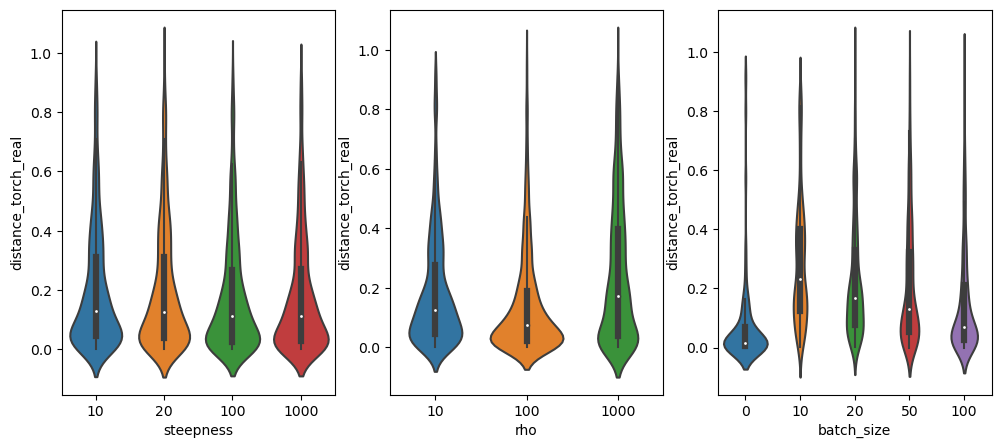

In [241]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 5))

sns.violinplot(data = histories_df, x = "steepness", y = "distance_torch_real", ax = axes[0])
sns.violinplot(data = histories_df, x = "rho", y = "distance_torch_real", ax = axes[1])
sns.violinplot(data = histories_df, x = "batch_size", y = "distance_torch_real", ax = axes[2])

batch_size = 0 means that we are not batching.

The estimation is much better without batching.

- Consider only batch_size = 0
- Repeat comparing rho and steepness

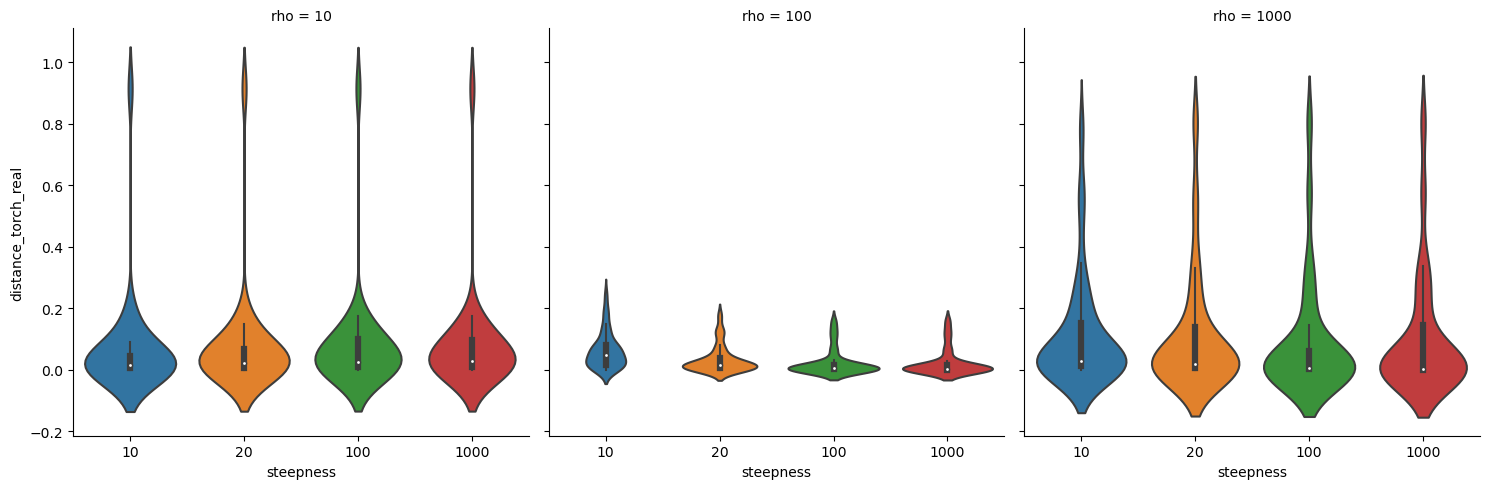

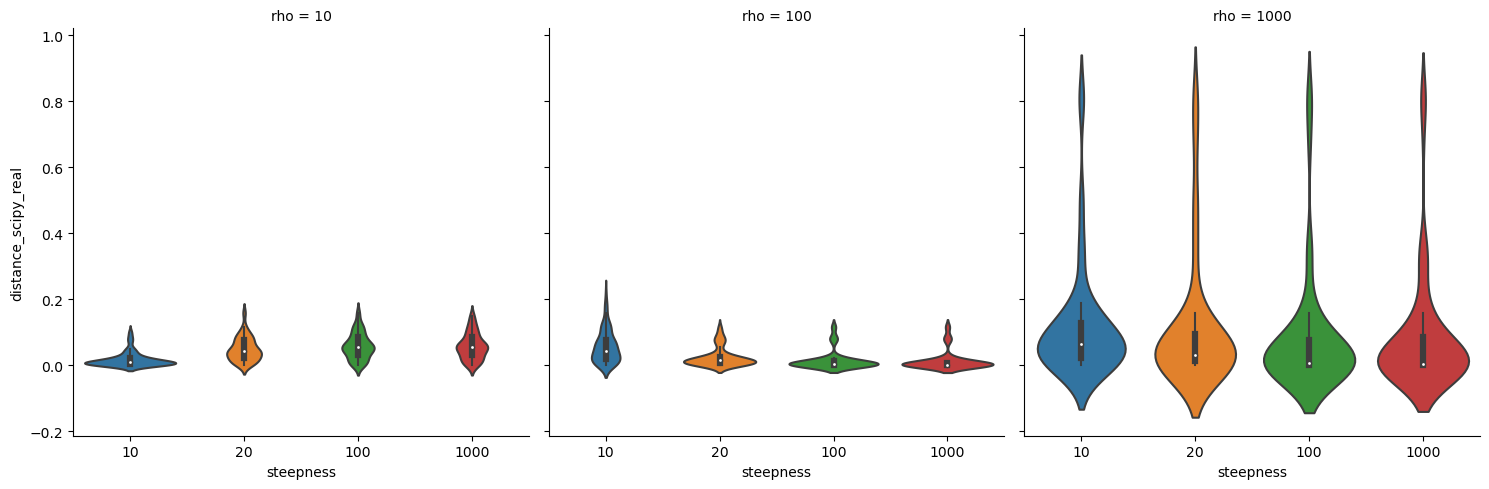

In [244]:
sns.catplot(data = histories_df.query("(batch_size == 0)"), col = "rho", x = "steepness", y = "distance_torch_real", kind = "violin")
sns.catplot(data = histories_df.query("(batch_size == 0)"), col = "rho", x = "steepness", y = "distance_scipy_real", kind = "violin")


What is the estimation at the varying of rho and N?


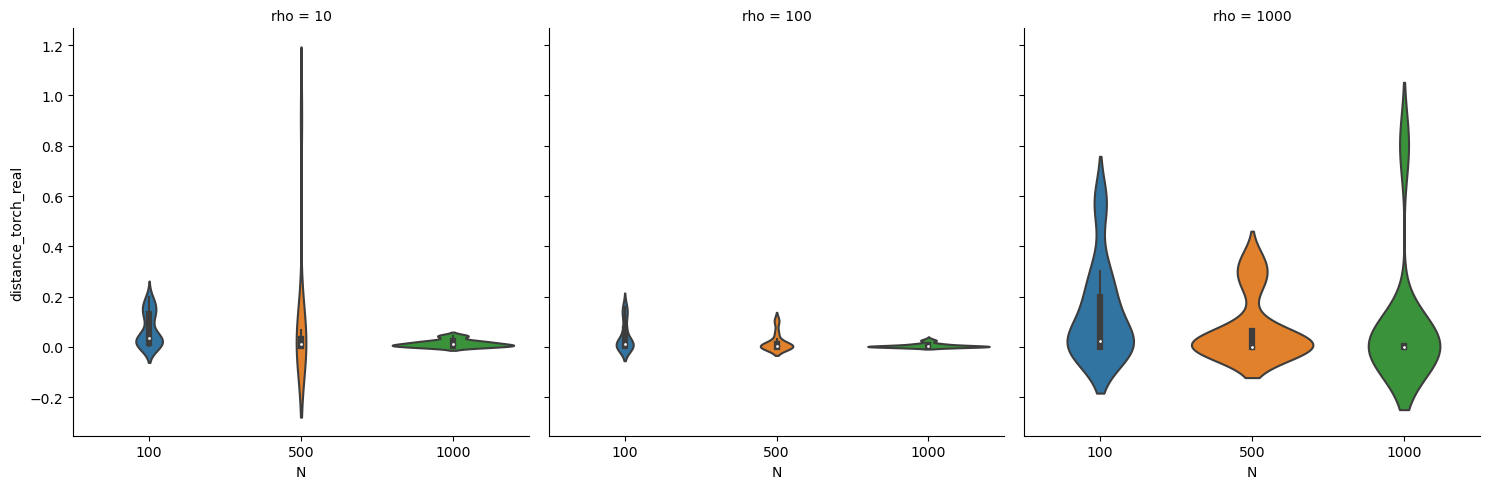

In [248]:
sns.catplot(data = histories_df.query("(steepness == rho)&(batch_size == 0)"), 
            col = "rho", x = "N", y = "distance_torch_real", kind = "violin")


In [228]:
histories_df.query("(steepness == rho)&(batch_size == 0)").groupby(["N", "rho"]).median()[["distance_torch_real", "distance_scipy_real"]].unstack()

/tmp/ipykernel_4056278/903023658.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  histories_df.query("(steepness == rho)&(batch_size == 0)").groupby(["N", "rho"]).median()[["distance_torch_real", "distance_scipy_real"]].unstack()


distance_torch_real                     distance_scipy_real            \
rho                   10       100      1000                  10       100   
N                                                                            
100             0.037378  0.012709  0.023930            0.011349  0.007646   
500             0.009947  0.003612  0.001520            0.008634  0.001711   
1000            0.011160  0.002087  0.000989            0.005620  0.002179   

                
rho       1000  
N               
100   0.021543  
500   0.002487  
1000  0.001170

How good is torch estimates compared to scipy?

In [249]:
histories_df.mean()[["distance_torch_real", "distance_scipy_real"]]

/tmp/ipykernel_4056278/2949845762.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  histories_df.mean()[["distance_torch_real", "distance_scipy_real"]]


distance_torch_real    0.189277
distance_scipy_real    0.061415
dtype: float64

In [250]:
histories_df.query("batch_size == 0").mean()[["distance_torch_real", "distance_scipy_real"]]

/tmp/ipykernel_4056278/394736892.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  histories_df.query("batch_size == 0").mean()[["distance_torch_real", "distance_scipy_real"]]


distance_torch_real    0.072398
distance_scipy_real    0.057614
dtype: float64

In [252]:
histories_df.query("(batch_size == 0)&(rho == 100)").mean()[["distance_torch_real", "distance_scipy_real"]]

/tmp/ipykernel_4056278/1424085148.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  histories_df.query("(batch_size == 0)&(rho == 100)").mean()[["distance_torch_real", "distance_scipy_real"]]


distance_torch_real    0.035904
distance_scipy_real    0.027494
dtype: float64

In [166]:
histories_df = histories_df.assign(rho = lambda x: pd.Categorical(x["rho"]), 
                                   batch_size = lambda x: pd.Categorical(x["batch_size"]))
histories_best_params = histories_df.query("(batch_size == 0)&(rho == 100)")

<AxesSubplot:xlabel='distance_torch_real', ylabel='epochs'>

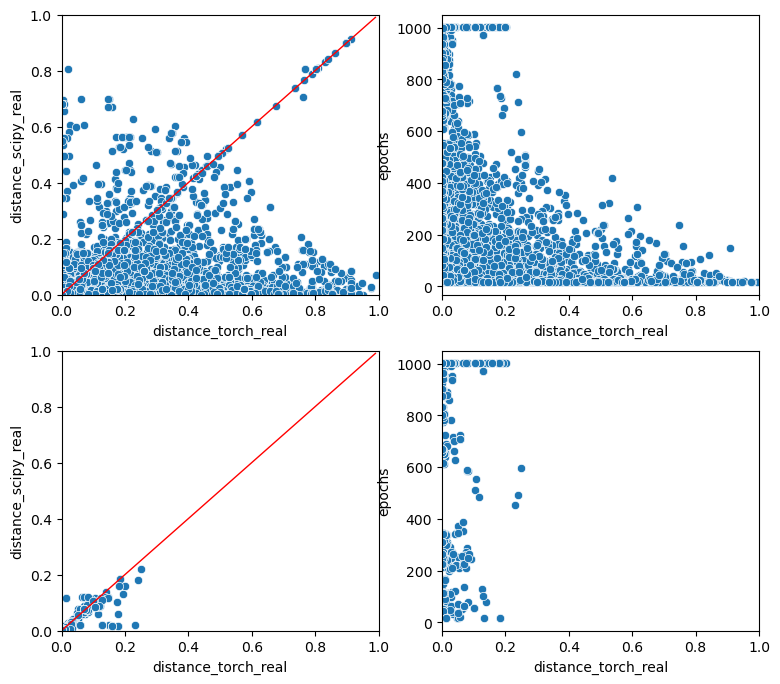

In [176]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 8))
for ax in [axes[0,0], axes[1,0]]:
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
for ax in [axes[0,1], axes[1,1]]:
    ax.set_xlim(0,1)

axes[0,0].plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = "red", linewidth = 1)
axes[1,0].plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = "red", linewidth = 1)

sns.scatterplot(data = histories_df, x = "distance_torch_real", y = "distance_scipy_real", ax = axes[0,0])
sns.scatterplot(data = histories_df, x = "distance_torch_real", y = "epochs", ax = axes[0,1])
sns.scatterplot(data = histories_best_params, x = "distance_torch_real", y = "distance_scipy_real", ax = axes[1,0])
sns.scatterplot(data = histories_best_params, x = "distance_torch_real", y = "epochs", ax = axes[1,1])



### How good is the estimate at the varying of epsilon, mu, and epsilon0?

<AxesSubplot:xlabel='distance_torch_real', ylabel='starting_distance'>

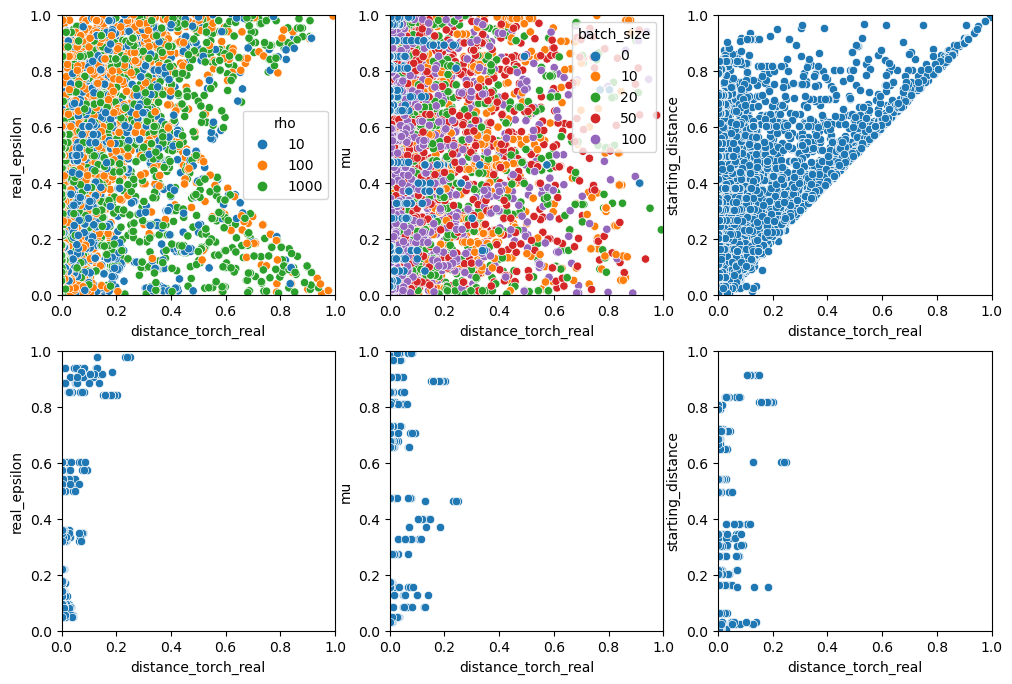

In [175]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8))
for _ in axes:
    for ax in _:
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)

        
sns.scatterplot(data = histories_df, x = "distance_torch_real", y = "real_epsilon", hue = "rho", ax = axes[0,0])
sns.scatterplot(data = histories_df, x = "distance_torch_real", y = "mu", hue = "batch_size", ax = axes[0,1])
sns.scatterplot(data = histories_df.assign(starting_distance = lambda x: np.abs(x["epsilon0"] - x["real_epsilon"])), x = "distance_torch_real", y = "starting_distance", ax = axes[0,2])
sns.scatterplot(data = histories_best_params, x = "distance_torch_real", y = "real_epsilon", ax = axes[1,0])
sns.scatterplot(data = histories_best_params, x = "distance_torch_real", y = "mu", ax = axes[1,1])
sns.scatterplot(data = histories_best_params.assign(starting_distance = lambda x: np.abs(x["epsilon0"] - x["real_epsilon"])), x = "distance_torch_real", y = "starting_distance", ax = axes[1,2])


### How does the estimates vary at the varying of T and N?

<AxesSubplot:xlabel='edge_per_t', ylabel='distance_torch_real'>

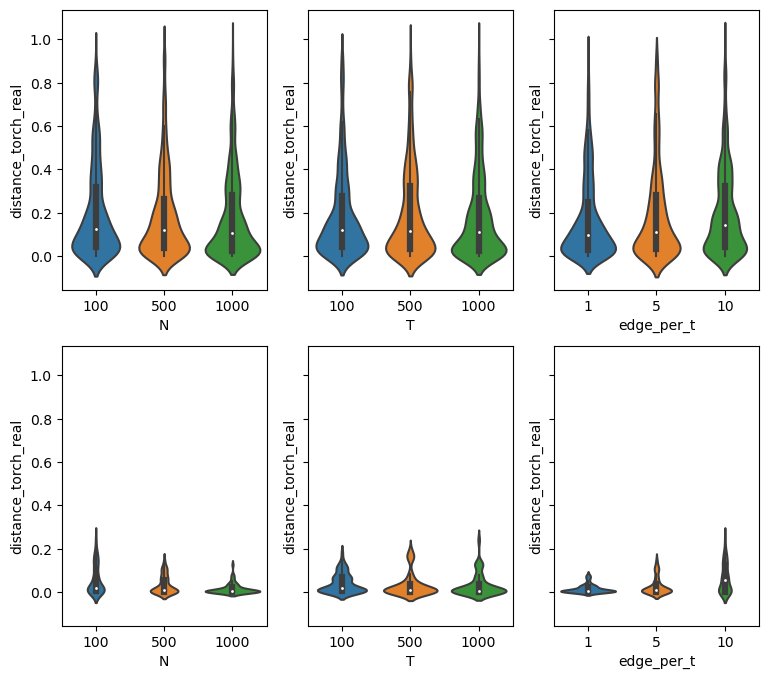

In [186]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (9, 8), sharey = True)

sns.violinplot(data = histories_df, y = "distance_torch_real", x = "N", ax = axes[0,0])
sns.violinplot(data = histories_df, y = "distance_torch_real", x = "T", ax = axes[0,1])
sns.violinplot(data = histories_df, y = "distance_torch_real", x = "edge_per_t", ax = axes[0,2])
sns.violinplot(data = histories_best_params, y = "distance_torch_real", x = "N", ax = axes[1,0])
sns.violinplot(data = histories_best_params, y = "distance_torch_real", x = "T", ax = axes[1,1])
sns.violinplot(data = histories_best_params, y = "distance_torch_real", x = "edge_per_t", ax = axes[1,2])



<AxesSubplot:xlabel='edge_per_t', ylabel='distance_scipy_real'>

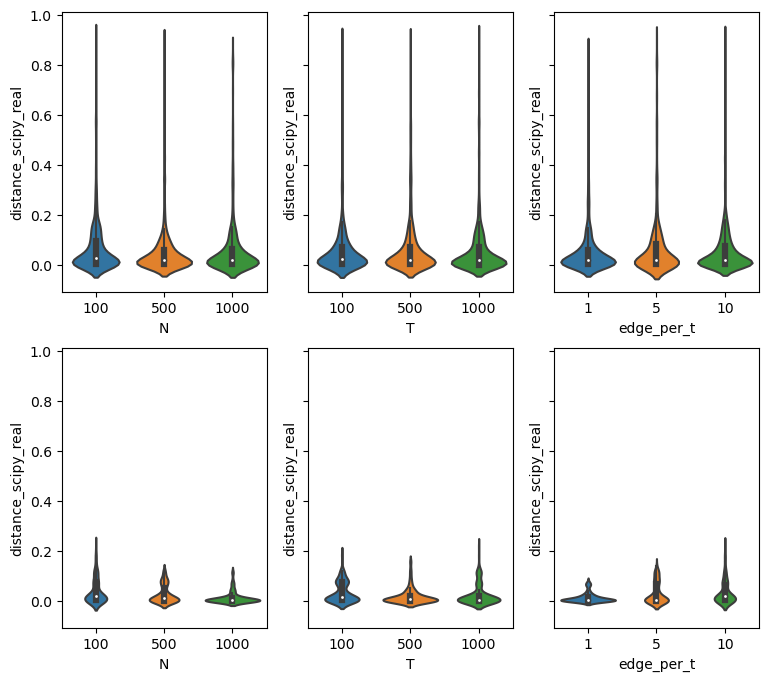

In [214]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (9, 8), sharey = True)

sns.violinplot(data = histories_df, y = "distance_scipy_real", x = "N", ax = axes[0,0])
sns.violinplot(data = histories_df, y = "distance_scipy_real", x = "T", ax = axes[0,1])
sns.violinplot(data = histories_df, y = "distance_scipy_real", x = "edge_per_t", ax = axes[0,2])
sns.violinplot(data = histories_best_params, y = "distance_scipy_real", x = "N", ax = axes[1,0])
sns.violinplot(data = histories_best_params, y = "distance_scipy_real", x = "T", ax = axes[1,1])
sns.violinplot(data = histories_best_params, y = "distance_scipy_real", x = "edge_per_t", ax = axes[1,2])



<AxesSubplot:xlabel='N', ylabel='tot_edges'>

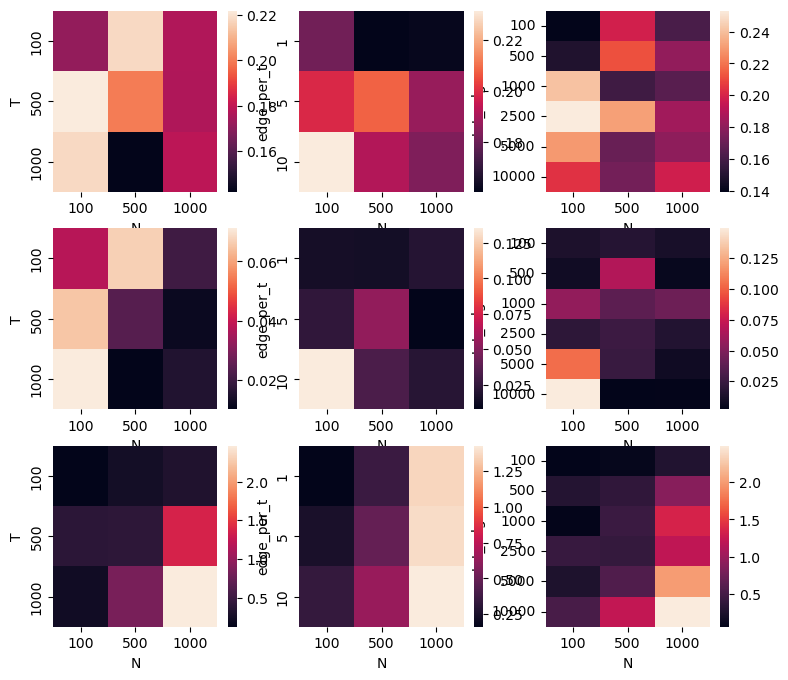

In [199]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (9, 8))

sns.heatmap(data = pd.pivot_table(histories_df, index = "T", columns =  "N", values = "distance_torch_real" ), ax = axes[0,0])
sns.heatmap(data = pd.pivot_table(histories_df, index = "edge_per_t", columns =  "N", values = "distance_torch_real" ), ax = axes[0,1])
sns.heatmap(data = pd.pivot_table(histories_df.assign(tot_edges = lambda x: x["T"] * x["edge_per_t"]), index = "tot_edges", columns =  "N", values = "distance_torch_real" ), ax = axes[0,2])
sns.heatmap(data = pd.pivot_table(histories_best_params, index = "T", columns =  "N", values = "distance_torch_real" ), ax = axes[1,0])
sns.heatmap(data = pd.pivot_table(histories_best_params, index = "edge_per_t", columns =  "N", values = "distance_torch_real" ), ax = axes[1,1])
sns.heatmap(data = pd.pivot_table(histories_best_params.assign(tot_edges = lambda x: x["T"] * x["edge_per_t"]), index = "tot_edges", columns =  "N", values = "distance_torch_real" ), ax = axes[1,2])
sns.heatmap(data = pd.pivot_table(histories_best_params, index = "T", columns =  "N", values = "time" ), ax = axes[2,0])
sns.heatmap(data = pd.pivot_table(histories_best_params, index = "edge_per_t", columns =  "N", values = "time" ), ax = axes[2,1])
sns.heatmap(data = pd.pivot_table(histories_best_params.assign(tot_edges = lambda x: x["T"] * x["edge_per_t"]), index = "tot_edges", columns =  "N", values = "time" ), ax = axes[2,2])


In [187]:
pd.pivot_table(histories_df, index = "N", columns =  "T", values = "distance_torch_real" )

T,100,500,1000
N,,,
100,0.171553,0.221830,0.217993
500,0.218046,0.199868,0.142058
1000,0.176763,0.176498,0.178881
